In [41]:
from desc import set_device

set_device("mps")

In [42]:
import jax

jax.config.update("jax_compilation_cache_dir", "../jax-caches")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [43]:
import numpy as np
from desc.backend import print_backend_info
from desc.coils import (
    CoilSet,
    FourierPlanarCoil,
    MixedCoilSet,
    initialize_modular_coils,
    initialize_saddle_coils,
)
import desc.examples
from desc.equilibrium import Equilibrium
from desc.plotting import plot_2d, plot_3d, plot_coils, plot_comparison
from desc.grid import LinearGrid
from desc.objectives import (
    ObjectiveFunction,
    CoilCurvature,
    CoilLength,
    CoilCurrentLength,
    CoilTorsion,
    CoilSetLinkingNumber,
    CoilSetMinDistance,
    LinkingCurrentConsistency,
    PlasmaCoilSetMinDistance,
    QuadraticFlux,
    ToroidalFlux,
    FixCoilCurrent,
    FixParameters,
)
from desc.optimize import Optimizer
from desc.integrals import compute_B_plasma
import time
import plotly.express as px
import plotly.io as pio

# This ensures Plotly output works in multiple places:
# plotly_mimetype: VS Code notebook UI
# notebook: "Jupyter: Export to HTML" command in VS Code
# See https://plotly.com/python/renderers/#multiple-renderers
pio.renderers.default = "plotly_mimetype+notebook"

print_backend_info()

DESC version=0.16.0.
Using JAX backend: jax version=0.7.2, jaxlib version=0.7.2, dtype=float64.
Using device: CPU, with 10.39 GB available memory.


In [44]:
def compute_average_normalized_field(
    field, eq, vacuum=False, chunk_size=None, B_plasma_chunk_size=None
):
    if B_plasma_chunk_size is None:
        B_plasma_chunk_size = chunk_size
    grid = LinearGrid(M=80, N=80, NFP=eq.NFP)
    if vacuum:
        # we can avoid the expensive plasma contribution calculation if we
        # just pass in the surface instead of the Equilibrium!
        Bn, surf_coords = field.compute_Bnormal(
            eq.surface,
            eval_grid=grid,
            chunk_size=chunk_size,
            B_plasma_chunk_size=B_plasma_chunk_size,
        )
    else:
        Bn, surf_coords = field.compute_Bnormal(
            eq,
            eval_grid=grid,
            chunk_size=chunk_size,
            B_plasma_chunk_size=B_plasma_chunk_size,
        )
    normalizing_field_vec = field.compute_magnetic_field(surf_coords)
    if not vacuum:
        # add plasma field to the normalizing field
        normalizing_field_vec += compute_B_plasma(
            eq, eval_grid=grid, chunk_size=B_plasma_chunk_size
        )
    normalizing_field = np.mean(np.linalg.norm(normalizing_field_vec, axis=1))
    return np.mean(np.abs(Bn)) / normalizing_field


def plot_field_lines(field, eq):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq.compute("R", grid=grid_trace)["R"]
    z0 = eq.compute("Z", grid=grid_trace)["Z"]
    fig, ax = desc.plotting.plot_surfaces(eq)
    fig, ax, data = desc.plotting.poincare_plot(
        field, r0, z0, NFP=eq.NFP, ax=ax, color="k", size=1, return_data=True
    )
    return fig, ax, data

In [45]:
from desc.io import load

eq = load("precise_QA_output.h5")[-1]

In [46]:
print(eq.NFP)

2


In [47]:
coilset = initialize_modular_coils(eq, num_coils=2, r_over_a=3.0).to_FourierXYZ()

# visualize the initial coilset
# we use a smaller than usual plot grid to reduce memory of the notebook file
plot_grid = LinearGrid(M=20, N=40, NFP=1, endpoint=True)
fig = plot_3d(eq, "|B|", grid=plot_grid)
fig = plot_coils(coilset, fig=fig)
fig.show()

/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



In [48]:
# number of points used to discretize coils. This could be different for each objective
# (eg if you want higher resolution for some calculations), but we'll use the same for all of them
coil_grid = LinearGrid(N=50)
# similarly define a grid on the plasma surface where B*n errors will be evaluated
plasma_grid = LinearGrid(M=25, N=25, NFP=eq.NFP, sym=eq.sym)


# define our objective function (we will use a helper function here to make it easier to change weights later)
weights = {
    "quadratic flux": 200,
    "coil-coil min dist": 100,
    "plasma-coil min dist": 10,
    "coil curvature": 500,
    "coil length": 200,
    "coil torsion": 10,
}


def make_vac_coil_obj(eq, coilset, weights_dict):
    obj = ObjectiveFunction(
        (
            QuadraticFlux(
                eq,
                field=coilset,
                # grid of points on plasma surface to evaluate normal field error
                eval_grid=plasma_grid,
                field_grid=coil_grid,
                vacuum=True,  # vacuum=True means we won't calculate the plasma contribution to B as it is zero
                weight=weights_dict["quadratic flux"],
                bs_chunk_size=10,
            ),
            CoilSetMinDistance(
                coilset,
                bounds=(0.05, np.inf),
                normalize_target=False,  # we're giving bounds in normalized units
                grid=coil_grid,
                weight=weights_dict["coil-coil min dist"],
                dist_chunk_size=2,  # this helps to reduce peak memory usage, needed to run on github CI
            ),
            PlasmaCoilSetMinDistance(
                eq,
                coilset,
                bounds=(0.15, np.inf),
                normalize_target=False,  # we're giving bounds in normalized units
                plasma_grid=plasma_grid,
                coil_grid=coil_grid,
                eq_fixed=True,  # Fix the equilibrium. For single stage optimization, this would be False
                weight=weights_dict["plasma-coil min dist"],
                dist_chunk_size=2,  # this helps to reduce peak memory usage, needed to run on github CI
            ),
            CoilCurvature(
                coilset,
                # this uses signed curvature, depending on whether it curves towards
                # or away from the centroid of the curve, with a circle having positive curvature.
                # We give the bounds normalized units, curvature of approx 1 means circular,
                # so we allow them to be a bit more strongly shaped
                bounds=(-1, 2),
                normalize_target=False,  # we're giving bounds in normalized units
                grid=coil_grid,
                weight=weights_dict["coil curvature"],
            ),
            CoilLength(
                coilset,
                bounds=(0, 2 * np.pi * (coilset[0].compute("length")["length"])),
                normalize_target=True,  # target length is in meters, not normalized
                grid=coil_grid,
                weight=weights_dict["coil length"],
            ),
            # CoilTorsion(
            #     coilset,
            #     bounds=(-1, 2),
            #     normalize_target=False,
            #     grid=coil_grid,
            #     weight=weights_dict["coil torsion"],
            # ),
        )
    )
    return obj


obj = make_vac_coil_obj(eq, coilset, weights)
## define our constraints
# we will constrain the current of one coil to avoid the trivial quadratic flux minimizing solution
# of zero coil current
coil_indices_to_fix_current = [False for c in coilset]
coil_indices_to_fix_current[0] = True
constraints = (FixCoilCurrent(coilset, indices=coil_indices_to_fix_current),)

# Alternatively, we could have used
# constraints = (ToroidalFlux(eq, coilset, eq_fixed=True),)
# to target the actual toroidal flux from the equilibrium, or
# constraints = (FixSumCoilCurrent(coilset),)
# to fix the sum of all the coil currents but as this is a vacuum calculation
# the specific value of the flux doesn't matter, we can always rescale the coil currents later.

# Pick an optimizer. For this problem with only linear constraints we can use a regular least squares method.
# if we used the ToroidalFlux constraint we would need to use a constrained optimization method
optimizer = Optimizer("lsq-exact")

(optimized_coilset,), _ = optimizer.optimize(
    coilset,
    objective=obj,
    constraints=constraints,
    maxiter=100,
    verbose=3,
    ftol=1e-4,
    copy=True,
)

Building objective: Quadratic flux
Precomputing transforms
Timer: Precomputing transforms = 24.5 ms
Building objective: coil-coil minimum distance
Building objective: plasma-coil minimum distance
Building objective: coil curvature
Precomputing transforms
Timer: Precomputing transforms = 3.82 ms
Building objective: coil length
Precomputing transforms
Timer: Precomputing transforms = 3.10 ms
Timer: Objective build = 88.1 ms
Building objective: fixed coil current
Building objective: fixed shift
Building objective: fixed rotation
Timer: Objective build = 14.2 ms
Timer: LinearConstraintProjection build = 9.44 ms
Number of parameters: 127
Number of objectives: 1546
Timer: Initializing the optimization = 114 ms

Starting optimization
Using method: lsq-exact
Solver options:
------------------------------------------------------------
Maximum Function Evaluations       : 501
Maximum Allowed Total Δx Norm      : inf
Scaled Termination                 : True
Trust Region Method                : q

In [49]:
optimized_coilset.save("optimized_coilset.h5")

In [50]:
normalized_field = compute_average_normalized_field(optimized_coilset, eq, vacuum=True)
print(f"<Bn> = {normalized_field:.3e}")

<Bn> = 1.115e-03


In [51]:
## visualize the optimized coilset and the normal field error
# passing in eq.surface avoids the unnecessary plasma field computation (as this is a vacuum eq)
fig = plot_3d(
    eq.surface, "B*n", field=optimized_coilset, field_grid=coil_grid, grid=plot_grid
)

fig = plot_coils(optimized_coilset, fig=fig)
fig.show()

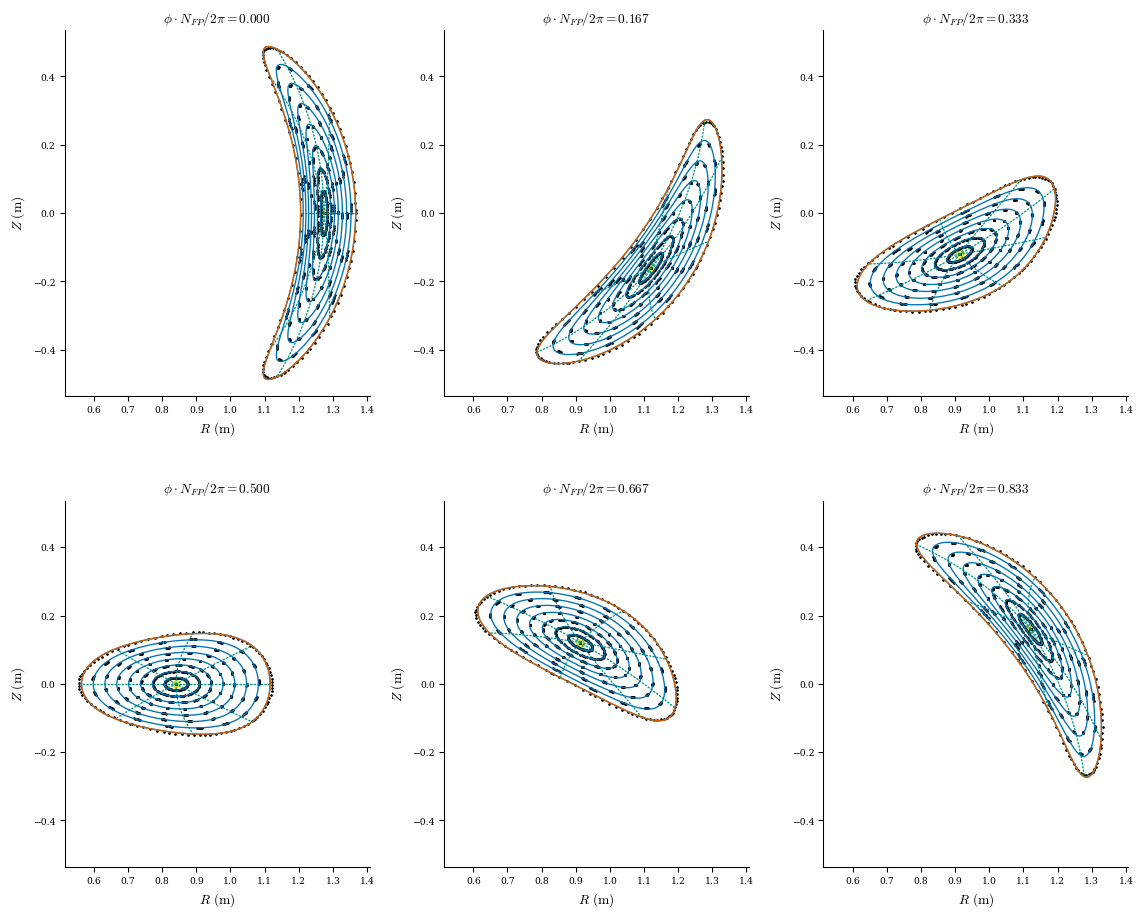

In [52]:
_, _, data_trace = plot_field_lines(optimized_coilset, eq)